In [19]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import scipy.stats as stats
from scipy.stats.kde import gaussian_kde

from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.base import BaseEstimator
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.cross_validation import cross_val_score

from sklearn import linear_model
from sklearn.preprocessing import scale, OneHotEncoder

df = pd.read_csv('./train.csv', index_col=0, parse_dates=True)
df_test = pd.read_csv('./test.csv', index_col=0, parse_dates=True)

Index([u'year', u'dayofweek', u'hourofday', u'season', u'holiday', u'workingday', u'weather', u'temp', u'atemp', u'humidity', u'windspeed', u'casual', u'registered', u'total'], dtype='object')


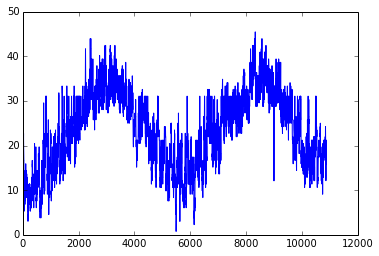

In [130]:
print df.columns
plt.plot(df.atemp)

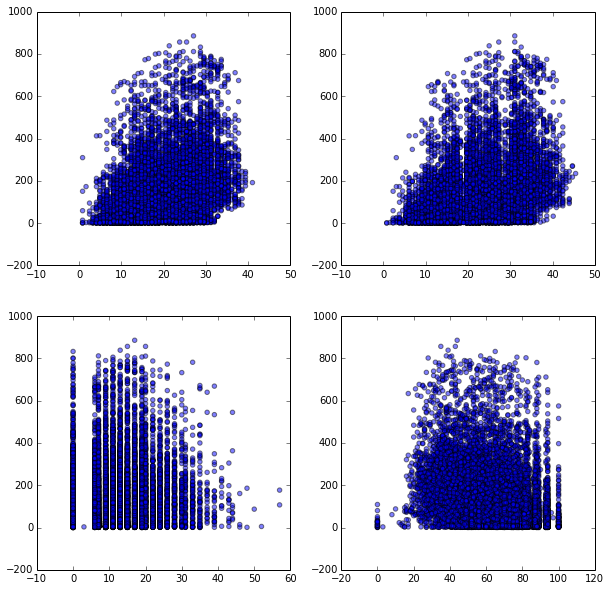

In [12]:
cols = ['temp', 'atemp', 'windspeed', 'humidity']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for col, ax in zip(cols, axes.flatten()):
    ax.scatter(df[col], df.registered, alpha=0.5)

In [118]:
def prepare_data(df, col_filter = None):
    '''
    Prepare categorical variables etc.
    '''
    
    # there is only observation with weather == 4 (2 in test data)
    df[df.weather == 4] = 3
    
    #compose new features
    if 'hourofday' not in df.columns:
        df.insert( loc= 0, column='hourofday', value=pd.Series(df.index.map(lambda x: int(x.strftime('%H'))), index=df.index))
    if 'dayofweek' not in df.columns:
        df.insert( loc=0, column='dayofweek', value=pd.Series(df.index.map(lambda x: int(x.strftime('%w'))), index=df.index))
    if 'year' not in df.columns:
        df.insert( loc=0, column='year', value=pd.Series(df.index.map(lambda x: 0 if int(x.strftime('%Y')) == 2011 else 1), index=df.index))
        
    binary_features = ['holiday', 'workingday', 'year']
    categorical_features = ['season', 'weather', 'hourofday', 'dayofweek'] 
    categorical_features = ['season', 'weather'] 
    categorical_features = []
    # column names after breaking down categorical ones
    encoded_columns = ['s'+str(x) for x in range(1,5)] + \
                        ['w'+str(x) for x in range(1,4)] + \
                        []
    encoded_columns = []
    #['h'+str(x) for x in range(0,24)] + ['d'+str(x) for x in range(0,7)] + \
    scalar_features = ['temp', 'atemp', 'humidity', 'windspeed'] + ['hourofday', 'dayofweek', 'season', 'weather']

    # Encode categorical features
    # enc = OneHotEncoder()
    # enc.fit(df[categorical_features])
    # arr = enc.transform( df[categorical_features] ).toarray()
    # df_cat1 = pd.DataFrame(arr, index=df.index, columns=encoded_columns)

    # add original binary features
    # df_aux = df_cat1.join(df[binary_features])
    df_aux = df[binary_features]

    #add relevant scalar features
    df_scaled = pd.DataFrame( scale( df[scalar_features] , axis=0), index=df.index, columns=scalar_features )
    df_final = df_aux.join(df_scaled)
    
    if col_filter:
        return df_final[col_filter]
    else:
        return df_final

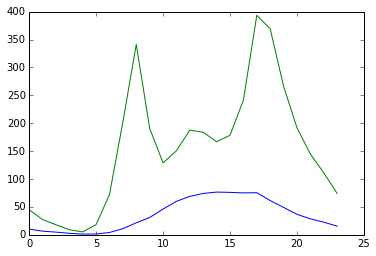

In [24]:

grouped = df.groupby(df.index.hour)
plt.plot(grouped[['casual', 'registered']].mean())


In [126]:
clf = linear_model.Lasso(alpha = 0.1, max_iter=5000)
param_grid = {'alpha': np.arange(0,2.0,0.1)}

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, verbose=0)

grid_search.fit( prepare_data(df), df['casual'])

print 'Params:', grid_search.best_params_
print 'Score:', grid_search.best_score_

Params: {'alpha': 0.20000000000000001}
Score: 0.359623729901


In [1]:
model = SVR()
param_grid = {'kernel': ['linear'], 'C':10.0 ** np.arange(3), 'gamma': 10.0 ** np.arange(-2, 1)}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=0)

grid_search.fit( prepare_data(df), df['registered'])

print 'Params:', grid_search.best_params_
print 'Score:', grid_search.best_score_

NameError: name 'SVR' is not defined

In [122]:
'''
random forest regressor

No need* to encode dayofweek and hourofday. Scores are 0.73...0.76.

* 
from: http://stackoverflow.com/a/17470183/1391947
On using one-hot-encoder - This is not true for all learning algorithms; decision trees and derived models such as random forests, 
if deep enough, can handle categorical variables without one-hot encoding.
'''
model = RandomForestRegressor(n_estimators=10)

param_grid = {'n_estimators' : [500]}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=0)

usage_type = 'casual'
print top_cols[usage_type][:10]
grid_search.fit( prepare_data(df), df[usage_type])
#grid_search.fit( prepare_data(df), df[usage_type])

print 'Score:', grid_search.best_score_, grid_search.best_params_

['hourofday', 'atemp', 'workingday', 'temp', 'humidity', 'year', 'windspeed', 'dayofweek', 'holiday']
Score: 0.736997592583 {'n_estimators': 500}


In [123]:
#estimators = {}
estimators[usage_type] = grid_search.best_estimator_

In [124]:
#plt.bar(range(len(est_registered.feature_importances_)), est_registered.feature_importances_)
top_cols = {}
for usage_type, aux_est in estimators.iteritems():
    print usage_type, len(aux_est.feature_importances_)

    top_cols[usage_type] = []
    i = 0
    for a,b in sorted(zip(aux_est.feature_importances_, prepare_data(df).columns), reverse=True):
        i += 1
        print i, round(a, 3), b
        top_cols[usage_type].append(b)
    
    print "\n\n"

registered 11
1 0.577 hourofday
2 0.152 workingday
3 0.092 year
4 0.054 season
5 0.032 temp
6 0.028 humidity
7 0.024 atemp
8 0.016 weather
9 0.012 dayofweek
10 0.01 windspeed
11 0.003 holiday



casual 11
1 0.351 hourofday
2 0.224 atemp
3 0.182 workingday
4 0.072 temp
5 0.06 humidity
6 0.036 year
7 0.022 windspeed
8 0.02 dayofweek
9 0.018 season
10 0.009 weather
11 0.005 holiday





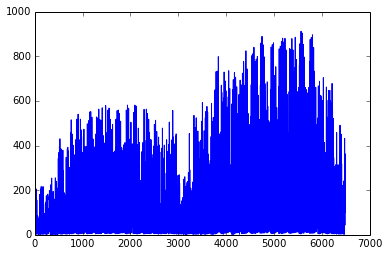

In [125]:
'''
output
'''
#test = grid_search.best_estimator_.predict( prepare_data(df_test) )
test1 = estimators['casual'].predict( prepare_data(df_test) )
test2 = estimators['registered'].predict( prepare_data(df_test) )
test = test1 + test2
prediction = pd.Series(data = np.round(test), index=df_test.index).astype('int')
prediction = prediction.map(lambda x: 0 if x < 0 else x)
prediction.to_csv('./results_ens_3.csv', index=True, index_label='datetime', header=['count'])
plt.plot(prediction)

In [128]:
'''
todo:
- read http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
- use feature selection methodologies
- http://mobilitylab.org/2014/01/27/explore-the-links-between-weather-and-capital-bikeshare-ridership/
- https://phillymotu.files.wordpress.com/2013/04/the-impact-of-weather-conditions-on-capital-bikeshare-trips.pdf
- add last hour/day temp/wether as feature - a'la give ppl time to go
'''
pass